In [1]:
import json
import csv
from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.dates import DateFormatter
import seaborn as sns 

In [2]:
# load llm bots
with open("../llm_bots.json", 'r') as f:
    first_seen_date = json.load(f)

llm_bots = set(first_seen_date.keys())
target_domains = ['nytimes.com', 'cnn.com', 'newyorker.com', 'vogue.com']

In [3]:
start_date_str = "20230101000000"
cutoff_date_str = "20250401000000"

start_date = datetime.strptime(start_date_str, "%Y%m%d%H%M%S")
cutoff_date = datetime.strptime(cutoff_date_str, "%Y%m%d%H%M%S")
num_days_expected_total = (cutoff_date - start_date).days+1

historical_robots_file = f"../measurement_data/historical_tranco_robots_data_20230101_20250407.json"
with open(historical_robots_file, 'r') as f:
    all_snapshots_data = json.load(f)

csv_file = f'../measurement_data/tranco_top-1m_20250407.csv'
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    rows = list(reader)
    total_rows = len(rows)
url2tranco_rank = {row[1]: row[0] for row in rows}

with open("../measurement_data/url2botinfo_20240411.json", 'r') as f:
    url2botinfo = json.load(f)

csv_file = f'../measurement_data/tranco_top-1m_20250407.csv'
with open(csv_file, 'r') as csvfile:
    reader = csv.reader(csvfile)
    rows = list(reader)
    total_rows = len(rows)
url2tranco_rank = {row[1]: row[0] for row in rows}

In [4]:
# for url, snapshots in all_snapshots_data.items():
#     print(f"{url2tranco_rank[url]}, {url}, {len(snapshots)}, {len(snapshots)/num_days_expected_total*100:.2f}% out of {num_days_expected_total} days");

In [5]:
def simplify_snapshots_data(original_snapshots):
    simplified_data = []
    
    for snapshot in original_snapshots:
        timestamp = snapshot['timestamp']
        html_content = snapshot['html_content']
        
        # Extract user-agent declarations from the html_content using regular expression.
        user_agents = set(re.findall(r'User-agent: (\S+)', html_content))
        
        simplified_data.append({'timestamp': timestamp, 'user_agents': list(user_agents)})
    
    return simplified_data


In [6]:
# Initialize a dictionary to hold changes for each domain.
domain_changes_all, domain_changes_llm= {}, {}
domain2added_all_bots, domain2added_llm_bots = {}, {}
for domain, snapshots in all_snapshots_data.items():
    # Simplify the snapshots data for the current domain.
    snapshots_data_simplified = simplify_snapshots_data(snapshots)
    
    # Initialize a dictionary to track changes in user agents across the snapshots for the current domain.
    changes_all, changes_llm = {}, {}
    added_unique_llm_bots, added_unique_all_bots = set(), set()
    # Use the first snapshot's user agents as the initial set for comparison, if available.
    if snapshots_data_simplified:
        previous_agents = set(snapshots_data_simplified[0]['user_agents'])
    
        for snapshot in snapshots_data_simplified[1:]:
            current_agents = set(snapshot['user_agents'])
            
            added_agents_llm = (current_agents - previous_agents).intersection(llm_bots)
            removed_agents_llm = (previous_agents - current_agents).intersection(llm_bots)
            added_unique_llm_bots = added_unique_llm_bots.union(added_agents_llm)

            added_agents_all = (current_agents - previous_agents)
            removed_agents_all = (previous_agents - current_agents)            
            added_unique_all_bots = added_unique_all_bots.union(added_agents_all)
            
            if added_agents_all or removed_agents_all:
                changes_all[snapshot['timestamp']] = {'added': list(added_agents_all), 'removed': list(removed_agents_all)}

            if added_agents_llm or removed_agents_llm:
                changes_llm[snapshot['timestamp']] = {'added': list(added_agents_llm), 'removed': list(removed_agents_llm)}
            
            # Update the previous_agents set for the next iteration.
            previous_agents = current_agents
    
        # Store the changes for the current domain.
        domain_changes_llm[domain] = changes_llm 
        domain_changes_all[domain] = changes_all 
        domain2added_all_bots[domain] = list(added_unique_all_bots)
        domain2added_llm_bots[domain] = list(added_unique_llm_bots)        
# for domain, unique_added_bots in dict(sorted(domain2added_llm_bots.items(), key=lambda item: -len(item[1]))).items():
#     print(f"{domain}")
#     print(len(unique_added_bots), unique_added_bots)
#     print(len(domain_changes_all[domain]), domain_changes_all[domain])
#     print('='*20)


In [7]:
domain_cumulative_counts = defaultdict(list)
dates = set()

for domain in target_domains:   
    vogue_petal_repeat_flag = 0
    changes = domain_changes_all[domain]
    unique_agents = set()
    for date, data in sorted(changes.items()):
        unique_agents.update(data['added']) 
        if vogue_petal_repeat_flag == 1 and domain == 'vogue.com' and (data['added'] == ['PetalBot'] or data['removed'] == ['PetalBot']):
            # vogue_petal_repeat_flag = 1
            # print(f"{domain} {date} {data['added']} {data['removed']}")
            continue
        if set(data['added']).intersection(set(list(first_seen_date.keys()))):
            if domain == 'vogue.com' and data['added'] == ['PetalBot']:
                vogue_petal_repeat_flag = 1
                                          
            # print(set(data['added']).intersection(set(list(first_seen_date.keys()))))
            domain_cumulative_counts[domain].append((date, len(unique_agents), True))
        else:
            domain_cumulative_counts[domain].append((date, len(unique_agents), False))
        dates.add(date)

# Sort dates for plotting
sorted_dates = sorted(list(dates))

In [8]:
domain_cumulative_counts['cnn.com']

[('20230817000629', 1, True),
 ('20231015000006', 2, True),
 ('20240417000040', 22, True),
 ('20241017172350', 24, False),
 ('20250328024925', 58, True),
 ('20250329031813', 58, False)]

In [9]:
domain_cumulative_counts['nytimes.com']

[('20230404000208', 1, True),
 ('20230818000935', 2, True),
 ('20231013002306', 3, True),
 ('20231221001142', 4, True),
 ('20240201000308', 4, False),
 ('20240210000130', 6, False),
 ('20240214000124', 6, False),
 ('20240215003325', 16, True),
 ('20240223002926', 17, False),
 ('20240228002819', 21, True),
 ('20240302002116', 22, False),
 ('20240308000909', 23, True),
 ('20240410000255', 28, True),
 ('20240514001845', 29, False),
 ('20240622000221', 30, True),
 ('20240726002500', 31, True),
 ('20240730004150', 33, True),
 ('20240807000121', 36, False),
 ('20240913000032', 37, True),
 ('20250314033904', 42, True)]

## Plot (Figure 5 in the paper)

nytimes.com 20
cnn.com 6
newyorker.com 12
vogue.com 11


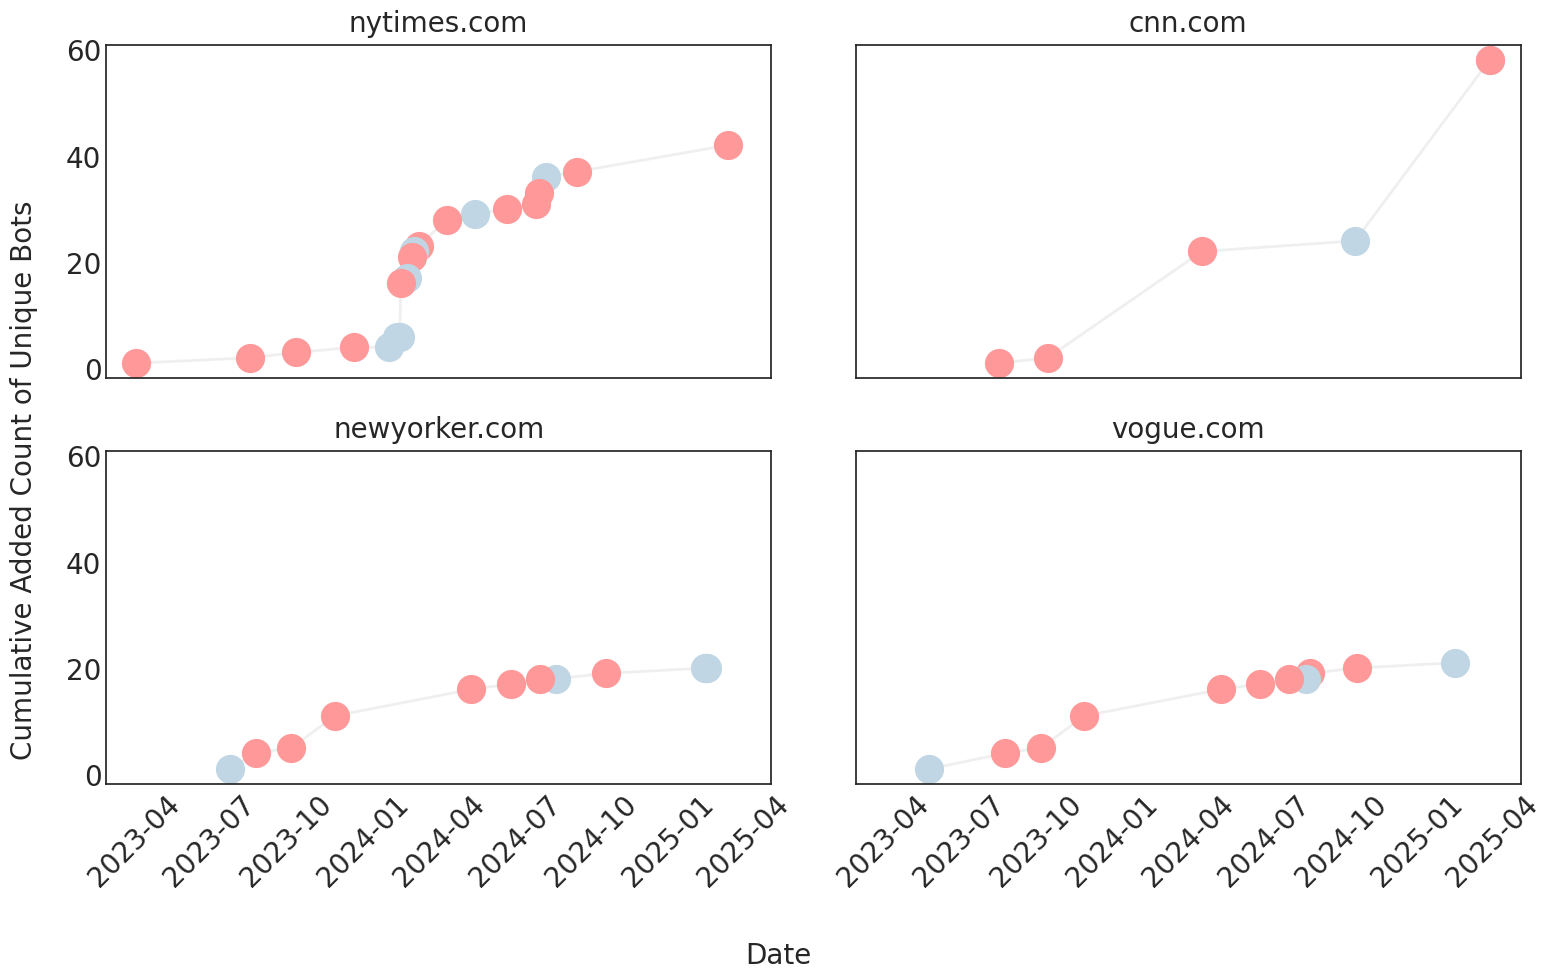

In [10]:
import matplotlib.pyplot as plt
from datetime import datetime

# Define pastel colors
pastel_red = '#ff9999'  # Light pastel red
pastel_blue = '#c0d6e4'  # Light pastel blue
pastel_gray = '#e0e0e0'  # Light pastel gray

# Apply a predefined style for a more polished look
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex='all', sharey='all')
axs = axs.flatten()

# Customizing the font size for the plots
plt.rcParams.update({'font.size': 20, 'axes.titlepad': 10})

for ax, (domain, data) in zip(axs, domain_cumulative_counts.items()):
    print(domain, len(data))
    dates, counts, added_llm = zip(*data)  # Unpacking data
    dates = [datetime.strptime(date, '%Y%m%d%H%M%S') for date in dates]

    # First plot the connecting line
    ax.plot(dates, counts, linestyle='-', color=pastel_gray,
            linewidth=2, alpha=0.5)  # Base line in blue

    # Then plot the dots
    for date, count, added in zip(dates[::-1], counts[::-1], added_llm[::-1]):
        dot_color = pastel_red if added else pastel_blue
        ax.plot(date, count, marker='o', linestyle='none',  # Remove individual lines
                color=dot_color, markersize=20)

    ax.set_title(domain, fontsize=20, pad=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

fig.supxlabel('Date', fontsize=20)
fig.supylabel('Cumulative Added Count of Unique Bots', fontsize=20)

plt.tight_layout()
# plt.savefig('plots/bots_inclusion_change.pdf', dpi=300)
plt.show()